In [ ]:
def file_to_list(path):
    data = []
    f = open(path, "r")
    for lines in f:
        line = lines.rstrip()
        data.append(float(line))
    return data

full_labels = file_to_list("data/labels_100000.txt")
full_pred_scores = file_to_list("data/pred_cons_100000.txt")
print(full_labels)
print(full_pred_scores)

Full Dataset Ground-Truth AUC: 0.9540521968
Data split among 24 clients
Decision Points: 10 --> AUC with DP: 0.8750834600524445, Ground-Truth AUC: 0.9657054227941176
Decision Points: 25 --> AUC with DP: 0.9426463320036587, Ground-Truth AUC: 0.9609477796052631
Decision Points: 50 --> AUC with DP: 0.9482666633357484, Ground-Truth AUC: 0.9581169446676938
Decision Points: 100 --> AUC with DP: 0.9588240125650879, Ground-Truth AUC: 0.9626427093632565
Decision Points: 500 --> AUC with DP: 0.9528292992131678, Ground-Truth AUC: 0.9541064390096516
Decision Points: 1000 --> AUC with DP: 0.952805072644207, Ground-Truth AUC: 0.9536449239967771


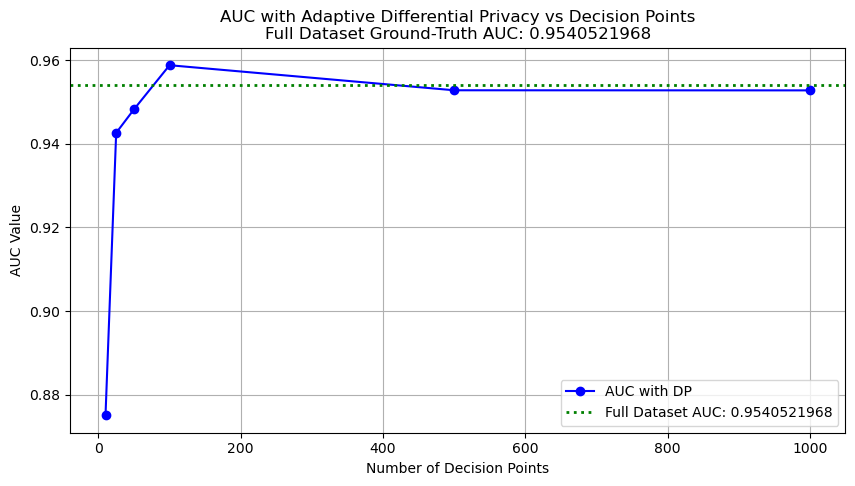

In [4]:
# same as the last code but added the AUC of the full datast

# this is the last version of the code
import numpy as np   # for numerical computation and array operations
import random        # for dataset shuffling
import matplotlib.pyplot as plt   # for plotting results
from sklearn.metrics import roc_auc_score    # to compute AUC

# load and Split Dataset
def file_to_list(path):
    """ Read a file and return a list of float values """
    with open(path, "r") as f:
        return [float(line.strip()) for line in f]

# load full dataset
full_labels = file_to_list("data/labels_100000.txt")
full_preds = file_to_list("data/pred_cons_100000.txt")
assert len(full_labels) == len(full_preds), "Mismatch in labels and predictions length!"

# computed the full dataset AUC for reference
full_auc = roc_auc_score(full_labels, full_preds)
print(f"Full Dataset Ground-Truth AUC: {full_auc}")

# decision points to test
decision_points_list = [10, 25, 50, 100, 500, 1000]
auc_values = []  # stored AUC values with DP
auc_ground_truth_values = []  # stored ground truth AUC values
diff_values = []  # stored absolute differences

# Shuffle and Split into Clients
num_clients = 24
split_size = len(full_labels) // num_clients
combined_data = list(zip(full_labels, full_preds))
random.shuffle(combined_data)
split_data = [combined_data[i * split_size:(i + 1) * split_size] for i in range(num_clients)]

# Extract labels and predictions for each client
clients_labels_preds = [(np.array(labels), np.array(preds)) for labels, preds in [zip(*split) for split in split_data]]
N = sum(len(labels) for labels, _ in clients_labels_preds)
print(f"Data split among {num_clients} clients")

# Reduce (to) decision points function
def reduce_decision_points(labels, preds, max_points):
    """ Reduce the number of decision points dynamically """
    unique_preds, indices = np.unique(preds, return_index=True)
    sorted_indices = np.argsort(-unique_preds)
    if len(unique_preds) > max_points:
        step = max(1, len(unique_preds) // max_points)
        sampled_indices = sorted_indices[::step]
    else:
        sampled_indices = sorted_indices
    return labels[indices[sampled_indices]], preds[indices[sampled_indices]]

# Compute cumulative TP & FP Function
def compute_cumulative_TP_FP(labels):
    """ Compute cumulative TP & FP after sorting """
    TP, FP = 0, 0
    TPR, FPR = [], []
    for label in labels:
        if label == 1:
            TP += 1
        else:
            FP += 1
        TPR.append(TP)
        FPR.append(FP)
    return np.array(TPR), np.array(FPR)

# Adaptive DP scaling
def get_adaptive_epsilon(num_decision_points, epsilon):
    """ Compute epsilon prime based on chosen epsilon """
    return epsilon / 2 * (np.log(num_decision_points + 5) + 2)

# def get_adaptive_sensitivity(dataset_size):
#     """ Adjust sensitivity based on dataset size """
#     return 1 / np.sqrt(dataset_size)

def add_adaptive_laplace_noise(data, laplace_scale):
    """ Adds scaled Laplace noise based on dataset size and prevents zeroing out values """
    noise = np.random.laplace(0, laplace_scale, size=data.shape)
    noisy_data = np.maximum(data + noise, np.percentile(data, 10))  # Improved noise clamping using 10th percentile
    return noisy_data

# user-defined privacy budget
epsilon = 1

# iteration through different decision points
for max_points in decision_points_list:
    reduced_clients_labels_preds = [reduce_decision_points(labels, preds, max_points=max_points) for labels, preds in clients_labels_preds]
    clients_TP_FP = [compute_cumulative_TP_FP(labels) for labels, _ in reduced_clients_labels_preds]
    min_length = min(len(tp) for tp, _ in clients_TP_FP)
    clients_TP_FP = [(tp[:min_length], fp[:min_length]) for tp, fp in clients_TP_FP]

    # Get adaptive privacy settings
    dataset_size = len(full_labels)
    epsilon_prime = get_adaptive_epsilon(max_points, epsilon)
    sensitivity = 1
    laplace_scale = sensitivity / epsilon_prime

    # Add DP noise to TP and FP before summing
    clients_TP_FP_noisy = [(add_adaptive_laplace_noise(tp, laplace_scale), add_adaptive_laplace_noise(fp, laplace_scale)) for tp, fp in clients_TP_FP]

    # Sum TP & FP across all clients (after noise is added per client)
    sum_TP_noisy = sum(tp for tp, _ in clients_TP_FP_noisy)
    sum_FP_noisy = sum(fp for _, fp in clients_TP_FP_noisy)

    # Compute AUC with DP
    numerator = sum(((sum_TP_noisy[i] + sum_TP_noisy[i-1]) * (sum_FP_noisy[i] - sum_FP_noisy[i-1]) / 2) for i in range(1, len(sum_TP_noisy)))

    # Normalize AUC
    total_TP = np.max(sum_TP_noisy)
    total_FP = np.max(sum_FP_noisy)
    auc_result = numerator / (total_TP * total_FP + 1e-4)  # Further refined correction factor
    auc_result = np.clip(auc_result, 0, 1)  # Ensure AUC is within valid range

    # Compute Ground-Truth AUC
    true_labels = np.concatenate([labels for labels, _ in reduced_clients_labels_preds])
    true_preds = np.concatenate([preds for _, preds in reduced_clients_labels_preds])
    ground_truth_auc = roc_auc_score(true_labels, true_preds)

    # Store results for plotting
    auc_values.append(auc_result)
    auc_ground_truth_values.append(ground_truth_auc)
    print(f"Decision Points: {max_points} --> AUC with DP: {auc_result}, Ground-Truth AUC: {ground_truth_auc}")


# plotted AUC vs Decision Points
plt.figure(figsize=(10, 5))
plt.plot(decision_points_list, auc_values, marker='o', label="AUC with DP", color='blue')
#plt.plot(decision_points_list, auc_ground_truth_values, marker='s', linestyle='dashed', label="Ground-Truth AUC", color='red')

# added a horizontal reference line for Full Dataset AUC
plt.axhline(y=full_auc, color='green', linestyle='dotted', linewidth=2, label=f"Full Dataset AUC: {full_auc:.10f}")

plt.xlabel("Number of Decision Points")
plt.ylabel("AUC Value")
plt.title(f"AUC with Adaptive Differential Privacy vs Decision Points\nFull Dataset Ground-Truth AUC: {full_auc:.10f}")
plt.legend()
plt.grid(True)
plt.show()
